# Text Summarization

To activate venv: enter "myvenv\Scripts\activate" in powershell

In [26]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy
#import regex as re

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from heapq import nlargest

### Load English language model from SpaCy

In [27]:
# "en_core_web_sm" is a pre-trained, small-size English language NLP model
# python -m spacy download en_core_web_sm
# Loads English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

### Read text file

In [28]:
# open and read text file
with open('DS9_Epsiode_104.txt') as f:
    lines = f.readlines()

In [29]:
# join text lines
text = ''
for line in lines:
    text += ' ' + line

### Preprocessing

In [30]:
def clean_text(text):
    """Removes extra white space. Can remove punctuation, but got better results leaving it in."""
    #cleaned_text = re.sub("[^a-zA-Z',.-]+", ' ', text)
    cleaned_text = " ".join(text.split()).lower()
    return cleaned_text

cleaned_text = clean_text(text)

### Analyze text with SpaCy

In [32]:
# create document object with SpaCy
doc = nlp(cleaned_text)

# count sentences
sentences = list(doc.sents)
print(f'The text is {len(sentences)} sentences long.')

The text is 1132 sentences long.


In [53]:
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks][:20])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"][:20])

Noun phrases: ['kira', 'dax', 'their posts', 'the turbolift', 'view', 'two human men', 'the twenty-fourth century equivalent', 'business attire', 'they', 'stern-faced and somewhat similar looking', 'one', 'a briefcase', 'they', 'agents', 'the federation department', 'temporal investigations', 'they', 'the turbolift', 'them', 'a smile']
Verbs: ['rise', 'carry', 'dress', 'carry', 'move', 'step', 'greet', 'welcome', 'expect', 'guess', 'exchange', 'crack', 'exchange', 'carry', 'move', 'take', 'study', 'want', 'get', 'want']


### Built-in attributes

In [34]:
# test built-in features
print('With white space  ', 'Is alphanumeric?  ', 'Is punctuation?  ', 'Is stop word?  ', 'Part of speech?')

# view features for 1 sentence
for token in sentences[10]:
    print(
        f"{str(token.text_with_ws):25}"
        f"{str(token.is_alpha):18}"
        f"{str(token.is_punct):16}"
        f"{str(token.is_stop):16}"
        f"{str(token.pos_)}"
     )

With white space   Is alphanumeric?   Is punctuation?   Is stop word?   Part of speech?
dax                      True              False           False           PROPN
(                        False             True            False           PUNCT
sly                      True              False           False           ADV
)                        False             True            False           PUNCT
i                        True              False           True            PRON
guess                    True              False           False           VERB
you                      True              False           True            PRON
boys                     True              False           False           NOUN
from                     True              False           True            ADP
temporal                 True              False           False           ADJ
investigations           True              False           False           NOUN
are                      True   

### Dependency parsing and part of speech tagging with SpaCy displacy

In [35]:
displacy.render(doc[:17], style="dep", jupyter=True, options={'distance':115})

### Named entity recognition with displacy

In [36]:
# view entities
ent_list = []

# Iterate over the predicted entities
for ent in doc.ents:
    if ent not in ent_list:
        ent_list.append(ent)
# Print the entity text and its label
for ent in ent_list[0:10]:
    print(ent.text, ent.label_)

kira PERSON
two CARDINAL
the twenty-fourth century DATE
the federation department of temporal investigations ORG
kira PERSON
kira PERSON
nine CARDINAL
kira PERSON
kira PERSON
two CARDINAL


In [37]:
displacy.render(doc[:200], style="ent", jupyter=True)

### Pattern matching
Using the matcher allows you to search the whole text for a custom pattern.

In [38]:
matcher = Matcher(nlp.vocab)

#create pattern as list of dicts
ds9_pattern = [
    {'TEXT': 'deep'},
    {'TEXT': 'space'},
    {'TEXT': 'nine'}
]

#use matcher to search text for a match
matcher.add("ds9_pattern", [ds9_pattern])

matches = matcher(doc)
print("Matches:", [doc[start:end].text for match_id, start, end in matches])
print("Doc, start index, & end index:", matches)

Matches: ['deep space nine', 'deep space nine']
Doc, start index, & end index: [(15026353168979911641, 79, 82), (15026353168979911641, 1498, 1501)]


### Add custom entities
Notice that not all names were recognized as entities above. Custom entities can be added using pattern matching.

In [39]:
# create list of patterns
# the 'OP':'?' matches 0 or 1 optional tokens
new_entities = [
    {'label': 'ENT', 'pattern':[{'LOWER': 'deep'}, {'LOWER': 'space'}, {'LOWER': 'nine'}], 'id': 'ds9'},
    {'label': 'ENT', 'pattern':[{'LOWER': 'dax'}], 'id': 'dax'},
    {'label': 'ENT', 'pattern':[{'LOWER': 'dulmur'}], 'id': 'dulmur'},
    {'label': 'ENT', 'pattern':[{'LOWER': 'lucsly'}], 'id': 'lucsly'}, 
    {'label': 'ENT', 'pattern':[{'LOWER': 'major', 'OP': '?'},{'LOWER': 'kira'}], 'id': 'kira'},
    {'label': 'ENT', 'pattern':[{'LOWER': 'captain', 'OP': '?'}, {'LOWER': 'sisko', 'OP': '?'}], 'id': 'sisko'}
]

In [40]:
# add pipeline for custom entity patterns
ruler = nlp.add_pipe('entity_ruler', before='ner')
ruler.add_patterns(new_entities)

In [45]:
# reload the doc with custom named entities added
doc = nlp(cleaned_text)
entities = [(ent.text, ent.label_, ent.ent_id_) for ent in doc.ents]
entities[:25]

[('kira', 'ENT', 'kira'),
 ('dax', 'ENT', 'dax'),
 ('two', 'CARDINAL', ''),
 ('the twenty-fourth century', 'DATE', ''),
 ('dulmur', 'ENT', 'dulmur'),
 ('lucsly', 'ENT', 'lucsly'),
 ('the federation department of temporal investigations', 'ORG', ''),
 ('kira', 'ENT', 'kira'),
 ('kira', 'ENT', 'kira'),
 ('deep space nine', 'ENT', 'ds9'),
 ('major kira', 'ENT', 'kira'),
 ('dulmur', 'ENT', 'dulmur'),
 ('dulmur', 'ENT', 'dulmur'),
 ('lucsly', 'ENT', 'lucsly'),
 ('lucsly', 'ENT', 'lucsly'),
 ('kira', 'ENT', 'kira'),
 ('dax', 'ENT', 'dax'),
 ('two', 'CARDINAL', ''),
 ('2', 'CARDINAL', ''),
 ('dulmur', 'ENT', 'dulmur'),
 ('kira', 'ENT', 'kira'),
 ('captain sisko', 'ENT', 'sisko'),
 ('kira', 'ENT', 'kira'),
 ('dax', 'ENT', 'dax'),
 ('sisko', 'ENT', 'sisko')]

In [46]:
# entities can be added to doc.ents
# create span for entities
ds9_span = Span(doc, 79, 82, label="ENT")
print(ds9_span.text, ds9_span.label_)



# add to doc.ents
# "unmodified" leaves current entities unchanged
doc.set_ents(entities=[ds9_span], default="unmodified")
# now included in entity list!
print([(ent.text, ent.label_) for ent in doc.ents if ent.text == "deep space nine"])

deep space nine ENT
[('deep space nine', 'ENT'), ('deep space nine', 'ENT')]


### Visualization with Word Cloud

In [47]:
# creating list of words in text and list of stopwords
text_words = []
stop_words= ["i'm", 'ext', 'rev', 'act', 'cut', 'int', 'clip', "don't", 
                   'end', "didn't", 'n', 'd', 'k', 'thing', 'fade', 'like', 'nods',
                   'close', 'open', 'standing', 'goes', 'door', 'voice', 
                   'room', 'continued', 'think', 'hand', 'begin', "you're", 
                   'sound', 'suddenly', 'want', 'table', 'people', 'will', 'turn', 'moment',
                   'hear', 'react', 's', 'continued', 'optical', 'k', 'rev', 'act',
                   'rev.', 'int', 'teaser', 'fade', 'in', 'ext.', 'optical',
                   'timecode', 'v.o.']

for token in doc:
    if (token.is_alpha) & (not token.is_stop) & (token.text not in stop_words):
        text_words.append(token.text)
    elif token.is_stop:
        stop_words.append(token.text)

In [48]:
# count which words are the most frequent
# note the character names are the most common because all the lines are marked with who is talking
# could do something about that later if needed
word_freq = Counter(text_words)
common_words = word_freq.most_common(5)
print (common_words)

[('sisko', 211), ('dax', 127), ('bashir', 109), ('kirk', 103), ('odo', 90)]


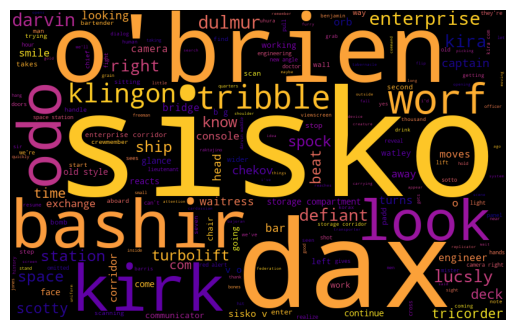

In [49]:
# making a word cloud for fun -- using most common words with stopwords removed
wc = WordCloud(background_color='black', colormap = 'plasma', 
               stopwords = stop_words, width = 800, height = 500).generate(cleaned_text)
plt.axis("off")
plt.imshow(wc)

### Extractive text summarization with SpaCy

In [50]:
# normalize text by dividing word frequency by max frequency
max_freq = word_freq.most_common(1)[0][1]
print(f'The word occurring the most often is "{word_freq.most_common(1)[0][0]}" which occurs {max_freq} times.')

print('\nNormalized words:')
for word in word_freq.keys():
    word_freq[word] = (word_freq[word] / max_freq)
word_freq.most_common(5)

The word occurring the most often is "sisko" which occurs 211 times.

Normalized words:


[('sisko', 1.0),
 ('dax', 0.6018957345971564),
 ('bashir', 0.5165876777251185),
 ('kirk', 0.4881516587677725),
 ('odo', 0.4265402843601896)]

In [57]:
# give sentences weight based on words they contain
sent_strength = {}
for sent in doc.sents:
    for word in sent:
        if word.text in word_freq.keys():
            if sent in sent_strength.keys():
                sent_strength[sent] += word_freq[word.text]
            else:
                sent_strength[sent] = word_freq[word.text]

dict

In [52]:
# get the sentences with the highest score
summary = nlargest(5, sent_strength, key=sent_strength.get)
for sent in summary: 
    print(sent)

119 enterprise - rec room - clip (optical) sisko and dax are sitting across from each other at a table in the f.g. as kirk and spock enter the room in the b.g. sisko is facing camera, while dax has her back to us.
in the background, kirk is saying -- kirk's voice - clip -- and as captain i want two things done... sisko and dax absently toss the tribbles in their hands away... (timecode 41:04-41:06) 141 k-7 - storage corridor - clip as a matching tribble comes out and hits kirk in the head.
50 resume sisko & dax dax smiles and continues to watch kirk & spock throughout the following: dax (sotto) i had no idea.
(timecode 36:35 - 36:43) 120 dax and sisko we're looking over sisko's shoulder at dax (we'll need to build a small piece of wall behind her).
(timecode 30:51 - 30:54) 96 resume sisko who reacts to kirk's entrance by looking over at... 97 dax standing at the engineering console opposite sisko.


### SUMMARY:
With a little editing, we have an extractive summary, consisting of the most important sentences (based on the scores we assigned).
The usefulness of an extractive summary can be limited depending on the context.
In a future project I will try out the LLM options with SpaCy.

-------------------------------------------------------------------------------------------


Enterprise, Rec room, Clip (optical): Sisko and Dax are sitting across from each other at a table in the f.g. as Kirk and Spock enter the room in the b.g. Sisko is facing camera, while Dax has her back to us.

In the background, Kirk is saying (Kirk's voice), Clip: And as captain i want two things done... 

Sisko and Dax absently toss the tribbles in their hands away... 

Storage corridor, Clip: as a matching tribble comes out and hits Kirk in the head.


Resume. Sisko & Dax. Dax smiles and continues to watch Kirk & Spock throughout the following.

Dax: I had no idea.


Dax and Sisko. We're looking over Sisko's shoulder at Dax (we'll need to build a small piece of wall behind her).

Resume. Sisko, who reacts to Kirk's entrance by looking over at Dax, standing at the engineering console opposite Sisko.

SOURCES:
1. https://medium.com/analytics-vidhya/text-summarization-using-spacy-ca4867c6b744
2. https://medium.com/@elizabeth.s.fawcett/performing-basic-lexical-analysis-on-webpage-text-with-spacy-f9a4a0cb7df9
3. https://www.st-minutiae.com/resources/scripts/
4. https://blog.floydhub.com/gentle-introduction-to-text-summarization-in-machine-learning/
5. https://spacy.io/usage/visualizers
6. https://practicaldatascience.co.uk/data-science/how-to-use-spacy-entityruler-for-custom-named-entity-recognition